<a href="https://colab.research.google.com/github/Jollyhrothgar/wordle/blob/main/Wordle_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Wordle is a word guessing game where the player needs to guess a five letter word. There are six chances to get the word right, and with each guess, you get information:

* Letters that are not in the word
* Letters that are in the word, but are not in the right position
* Letters thar are in the word and in the right position

## Games

[Wordle](https://www.powerlanguage.co.uk/wordle/)
[Lewdle](https://www.lewdlegame.com/)

# Strategy

Since the first word is a complete guess, the optimal guess is the one that obtains the most information. Some strageies:

## Letter frequencies

Goal: try to eliminate as many letters as possible.

1. Pick a word with distinct letters
2. Choose a word that contains the most common letters
3. First guess eliminates the most uncertainty

## Letter position frequencies

Goal: try to eliminate as many positions as possible

1. Pick a word that has distinct letters, as well as most common letter positions
2. Choose word that eliminates the most position-letter pairs
3. First guess (hopefully) eliminates both a letter AND a position.

In [1]:
#@title Imports
import urllib.request as request
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import re

In [23]:
#@title Utils

def load_wordlist_from_url(url):
  """Assume URL hosts a plan newline deliminated wordlist, and load to array"""
  return [line.decode("utf-8").strip().lower() for line in request.urlopen(url)]

def make_word_df(word_list):
  """Create the word dataframe data structure"""
  words = pd.DataFrame(word_list, columns=['word'])
  words[1] = words['word'].apply(lambda x: x[0])
  words[2] = words['word'].apply(lambda x: x[1])
  words[3] = words['word'].apply(lambda x: x[2])
  words[4] = words['word'].apply(lambda x: x[3])
  words[5] = words['word'].apply(lambda x: x[4])

  return words

class Guesser(object):
  def __init__(self, word_df):
    self.word_df = word_df
    self.letter_regex = {
      1:'[abcdefghijklmnopqrstuvwxyz]',
      2:'[abcdefghijklmnopqrstuvwxyz]',
      3:'[abcdefghijklmnopqrstuvwxyz]',
      4:'[abcdefghijklmnopqrstuvwxyz]',
      5:'[abcdefghijklmnopqrstuvwxyz]'
    }
    self.solved = {
      1: False,
      2: False,
      3: False,
      4: False,
      5: False,
    }

    self.compute_probability_and_frequency()
  
  def get_filtered_words(self):
    """Returns original wordlist filtered according to letter_regex"""
    regex = ''.join(self.letter_regex.values())
    return self.word_df[self.word_df['word'].str.contains(regex)]

  def snapshot_letter_regex(self):
    self._letter_regex = copy.deepcopy(self.letter_regex)

  def restore_letter_regex_snapshot(self):
    self.letter_regex = copy.deepcopy(self._letter_regex)

  def compute_probability_and_frequency(self):
    """Given a word_list of words, compute the joint probability of all letter
    positions."""

    word_df = self.get_filtered_words()
  
    letter_frequency = pd.Series(
        [letter for word in word_df['word'].values for letter in word]
    ).value_counts(normalize=True).sort_index()
  
    position_frequency = pd.concat(
      [
        word_df[1].value_counts(),
        word_df[2].value_counts(),
        word_df[3].value_counts(),
        word_df[4].value_counts(),
        word_df[5].value_counts()
      ],
      axis=1
    ).fillna(0)
    position_joint = position_frequency.div(position_frequency.sum()).sort_index()
  
    self.position_joint = position_joint  
    self.letter_frequency = letter_frequency

  def add_hint(self, letter, location=None):
    """Add a hint about information in the word

    letter: a lowercase letter in the alphabet
    location: takes on following values / meaning:
      None: the letter is not in the word
      (-1, -2, -3, -4, -5): the letter is in the word, but NOT in the position
      (1, 2, 3, 4, 5): the letter is in the position.
    state: True or False - true if the position has the letter, false if it
      doesn't.
    """

    if location is None:
        for pos in self.letter_regex:
          if not self.solved[pos]:
            self.letter_regex[pos] = self.letter_regex[pos].replace(letter, '')
    else:
      if location > 0:
        if not self.solved[location]:
          self.letter_regex[location] = f'[{letter}]'
      else:
        location = abs(location)
        if not self.solved[location]:
          self.letter_regex[location] = self.letter_regex[location].replace(letter, '')

    for pos in self.letter_regex:
      letter_set = ''.join(l for l in self.letter_regex[pos] if l in 'abcdefghijklmnopqrstuvwxyz')
      if len(letter_set) == 1:
        self.solved[pos] = True
    
    self.compute_probability_and_frequency()

  def plot_words(self):
    words_df = self.compute_probability_and_frequency()

    fig, (ax_l, ax_r) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

    # Letter Joint
    sns.heatmap(self.position_joint, cmap='Blues', annot=True, fmt='.3f', ax=ax_l)
    ax_l.set_title('Wordle Joint Distribution \n $P(letter, position)$')
  
    # Letter frequency
    self.letter_frequency.plot.bar(
        title='letter frequency',
        xlabel='letter',
        ylabel='frequency',
        ax=ax_r
    )

In [24]:
#@title choose a word list
url = "https://raw.githubusercontent.com/Jollyhrothgar/wordle/main/wordle.txt" #@param ["https://raw.githubusercontent.com/Jollyhrothgar/wordle/main/lewdle.txt", "https://raw.githubusercontent.com/Jollyhrothgar/wordle/main/wordle.txt"]
wordlist = load_wordlist_from_url(url)

print(f"Wordlist conistst of a vocabulary of {len(wordlist)} words.")

Wordlist conistst of a vocabulary of 12972 words.


# Strategy - Example 1

Here, we manually execute a hybrid strategy, using the live wordle UI to validate responses.

The general strategy I used was:

1. Choose the most likely letter-position, so long as it was in the top 5 of the current known set.

2. Refilter the list with the guess in step `1.`, repeat step 1.

3. Continue until we have all guessed letters and positions.

This strategy reduced the word-list length in the first step by a factor of 10, but seemed to suffer as the list became shorter and shorter.

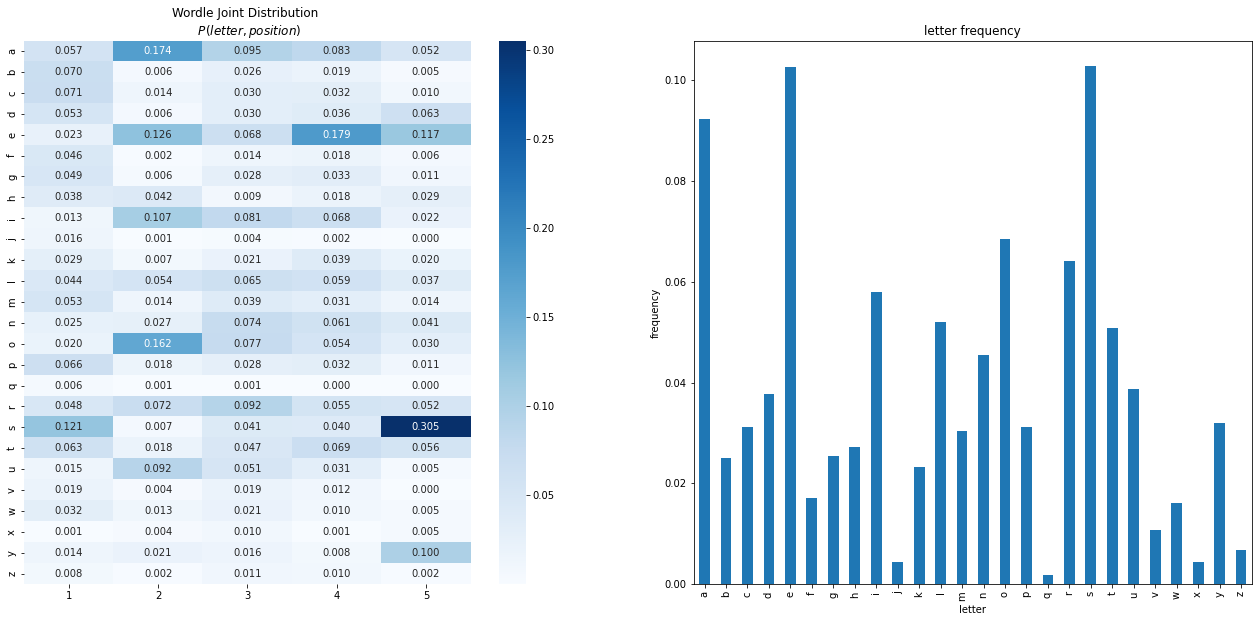

In [25]:
words = make_word_df(wordlist)
game = Guesser(word_df=words)
game.plot_words()

In [26]:
game.add_hint(letter='r')
game.add_hint(letter='e')
game.add_hint(letter='a')
game.add_hint(letter='s')
game.add_hint(letter='l', location=4)

In [27]:
game.snapshot_letter_regex()

In [28]:
game.add_hint(letter='o', location=-2)
game.add_hint(letter='d')
game.add_hint(letter='i')
game.add_hint(letter='y')

In [29]:
game.snapshot_letter_regex()

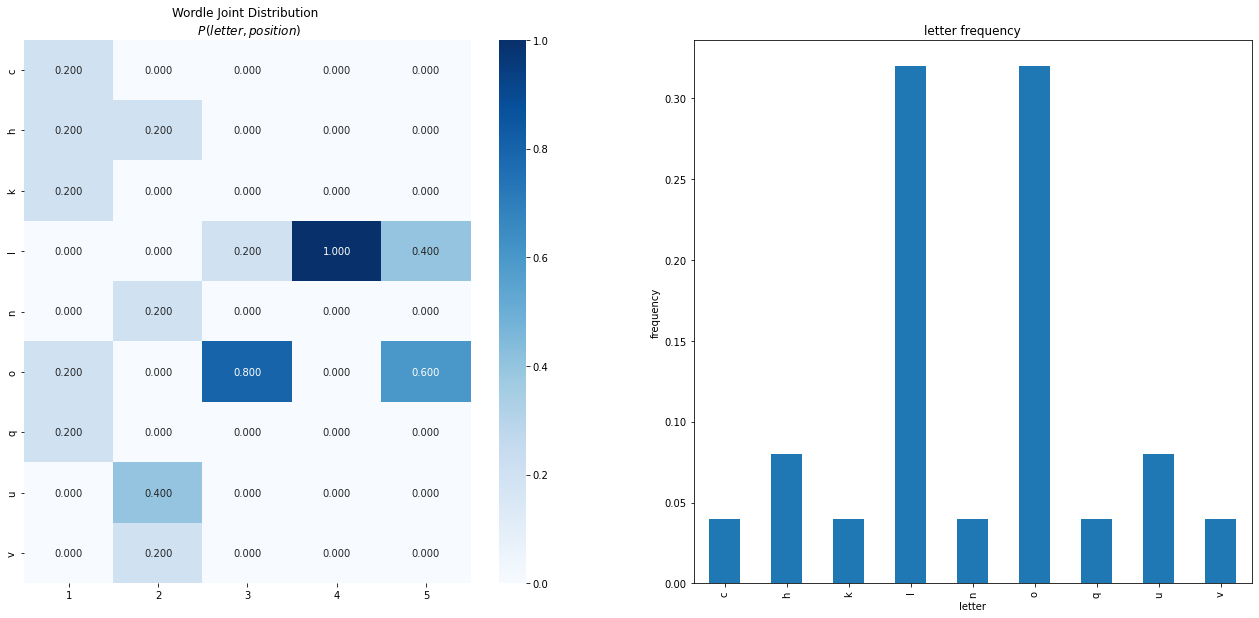

In [30]:
game.plot_words()

In [31]:
game.get_filtered_words()

,word,1,2,3,4,5
219,knoll,k,n,o,l,l
3904,cholo,c,h,o,l,o
6538,hullo,h,u,l,l,o
8811,ovolo,o,v,o,l,o
9601,quoll,q,u,o,l,l


In [32]:
game.add_hint(letter='c')
game.add_hint(letter='h')
game.add_hint(letter='o', location=3)
game.add_hint(letter='o')

In [33]:
game.solved

{1: False, 2: False, 3: True, 4: True, 5: False}

In [34]:
game.get_filtered_words()

,word,1,2,3,4,5
219,knoll,k,n,o,l,l
9601,quoll,q,u,o,l,l


In [35]:
game.add_hint(letter='l', location=5)
game.add_hint(letter='q', location=-1)

In [36]:
game.get_filtered_words()

,word,1,2,3,4,5
219,knoll,k,n,o,l,l


In [37]:
game.snapshot_letter_regex()